In [31]:
import pandas as pd
import numpy as np

!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
#!pip install torch 
!pip install fastai==0.7.0


from fastai.structured import *
from fastai.column_data import *

    100% |████████████████████████████████| 592.3MB 1.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: torch 0.3.1
    Uninstalling torch-0.3.1:
      Successfully uninstalled torch-0.3.1
    100% |████████████████████████████████| 2.0MB 9.8MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [35]:
torch.cuda.is_available()

True

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ssub = pd.read_csv('sample_submission.csv')

In [37]:
train.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


In [38]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [39]:
train.isnull().sum(), train.isna().sum()

(date     0
 store    0
 item     0
 sales    0
 dtype: int64, date     0
 store    0
 item     0
 sales    0
 dtype: int64)

In [40]:
add_datepart(train, "date", drop=False)
add_datepart(test, "date", drop=False)
train.head()

,date,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013-01-01,1,1,13,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,2013-01-02,1,1,11,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
2,2013-01-03,1,1,14,2013,1,1,3,3,3,False,False,False,False,False,False,1357171200
3,2013-01-04,1,1,13,2013,1,1,4,4,4,False,False,False,False,False,False,1357257600
4,2013-01-05,1,1,10,2013,1,1,5,5,5,False,False,False,False,False,False,1357344000


In [41]:
cat_vars = list(train)

[cat_vars.remove(col) for col in ['sales', 'Elapsed', 'date']]

for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
apply_cats(test, train)

/usr/local/lib/python3.6/dist-packages/fastai/structured.py:200: RuntimeWarning: None of the categories were found in values. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)


In [0]:
for v in ['sales', 'Elapsed']:
    train[v] = train[v].fillna(0).astype('float32')
    if v in test:
        test[v] = test[v].fillna(0).astype('float32')

In [0]:
train = train.set_index('date')
test = test.set_index('date')

df, y, nas, mapper = proc_df(train, 'sales', do_scale=True)

In [0]:
test['sales'] = 0
df_test, _, nas, mapper = proc_df(test, 'sales', do_scale=True, skip_flds=['id'], mapper=mapper, na_dict=nas)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 15 columns):
store               913000 non-null int8
item                913000 non-null int8
Year                913000 non-null int8
Month               913000 non-null int8
Week                913000 non-null int8
Day                 913000 non-null int8
Dayofweek           913000 non-null int8
Dayofyear           913000 non-null int16
Is_month_end        913000 non-null int8
Is_month_start      913000 non-null int8
Is_quarter_end      913000 non-null int8
Is_quarter_start    913000 non-null int8
Is_year_end         913000 non-null int8
Is_year_start       913000 non-null int8
Elapsed             913000 non-null float64
dtypes: float64(1), int16(1), int8(13)
memory usage: 27.0 MB


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 15 columns):
store               45000 non-null int8
item                45000 non-null int8
Year                45000 non-null int8
Month               45000 non-null int8
Week                45000 non-null int8
Day                 45000 non-null int8
Dayofweek           45000 non-null int8
Dayofyear           45000 non-null int16
Is_month_end        45000 non-null int8
Is_month_start      45000 non-null int8
Is_quarter_end      45000 non-null int8
Is_quarter_start    45000 non-null int8
Is_year_end         45000 non-null int8
Is_year_start       45000 non-null int8
Elapsed             45000 non-null float64
dtypes: float64(1), int16(1), int8(13)
memory usage: 1.3 MB


In [0]:
val_idx = np.flatnonzero((df.index<datetime.datetime(2018,1,1)) & (df.index>=datetime.datetime(2017,10,1)))

In [0]:
def inv_y(a): return np.exp(a) - 1

def smape(y_pred, targ):
    targ = inv_y(targ)
    pred = inv_y(y_pred)
    ape = 2 * np.abs(pred - targ) / (np.abs(pred) + np.abs(targ))
    return ape.mean() 

yl = np.log1p(y)
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [0]:
md = ColumnarModelData.from_data_frame('data', val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [50]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('store', 11),
 ('item', 51),
 ('Year', 6),
 ('Month', 13),
 ('Week', 54),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 367),
 ('Is_month_end', 3),
 ('Is_month_start', 3),
 ('Is_quarter_end', 3),
 ('Is_quarter_start', 3),
 ('Is_year_end', 3),
 ('Is_year_start', 3)]

In [51]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(11, 6),
 (51, 26),
 (6, 3),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

In [0]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [53]:
lr = 1e-3
m.lr_find()

 60%|█████▉    | 4031/6774 [01:45<01:12, 37.95it/s, loss=0.122]

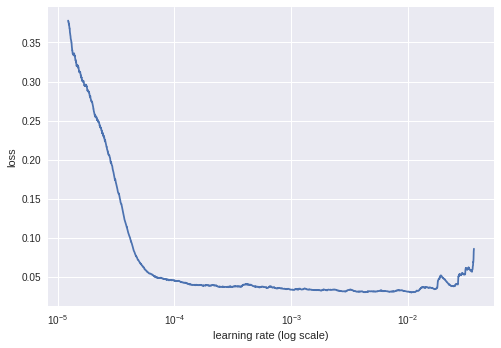

In [54]:
m.sched.plot(100)

In [0]:
lr = 10 ** -4.4 #1e-5

In [0]:
m.fit(lr, 3, metrics=[smape])

 10%|█         | 696/6774 [00:14<02:04, 48.67it/s, loss=0.0506]

In [0]:
m.save('item_revenue_E3')

In [58]:
m.fit(lr, 2, cycle_len=2, cycle_mult=3, metrics=[smape])

epoch      trn_loss   val_loss   smape      
    0      0.027304   0.026445   0.12664   
    1      0.027372   0.025829   0.125452  
    2      0.027235   0.026686   0.127022  
    3      0.026226   0.0258     0.125107  
    4      0.027563   0.02598    0.125634  
    5      0.026819   0.025723   0.125069  
    6      0.028578   0.025877   0.125445  
    7      0.027047   0.02533    0.125092  
    8      0.026784   0.02537    0.124237  
    9      0.027016   0.025356   0.124447  
    10     0.025502   0.025378   0.124318  
    11     0.027248   0.025376   0.124423  
    12     0.026286   0.025566   0.124686  
    13     0.026516   0.025468   0.124506  


[array([0.02547]), 0.12450608294628053]

In [0]:
m.save('best_model')

In [0]:
m.load('best_model')

In [0]:
x,y=m.predict_with_targs()

In [0]:
smape(x, y)

In [0]:
pred_test=m.predict(True)
pred_test=np.exp(pred_test) - 1

In [0]:
test['sales'] = pred_test
test[['id','sales']].to_csv('predictions.csv', index=False)